# <u>Measuring sediments in Lake Tempe</u>

**Contents** 

  - [Background](#Background)
    - [Notebook overview](#Notebook-overview)
    - [Suspended sediments](#Suspended-sediments)
  - [Notebook setup](#Notebook-setup)
  - [Analysis parameters](#Analysis-parameters)
    - [Spatial and temporal window](#Spatial-and-temporal-window)
    - [Datacube query](#Datacube-query)
  - [Sentinel-2 dataset](#Sentinel-2-dataset)
    - [Data load](#Data-load)
    - [Data clean-up](#Data-clean-up)
  - [Lake boundary](#Lake-boundary)
    - [Loading up the shapefile](#Loading-up-the-shapefile)
    - [Raster mask](#Raster-mask)
    - [Masking the data](#Masking-the-data)
  - [Filtering out land &#40;i.e. non-water&#41; pixels](#Filtering-out-land-&#40;i.e.-non-water&#41;-pixels)
    - [Water index](#Water-index)
    - [Removing non-water pixels](#Removing-non-water-pixels)
  - [TSS analysis](#TSS-analysis)
    - [TSS calculation](#TSS-calculation)
    - [Selected displays](#Selected-displays)
      - [Individual time slices](#Individual-time-slices)
      - [Temporal aggregation &#40;1&#41;](#Temporal-aggregation-&#40;1&#41;)
      - [Temporal aggregation &#40;2&#41;](#Temporal-aggregation-&#40;2&#41;)
    - [Temporal statistics &#40;standard&#41;](#Temporal-statistics-&#40;standard&#41;)
    - [Robust statistics &#40;using Dask&#41;](#Robust-statistics-&#40;using-Dask&#41;)
      - [Approach](#Approach)
      - [Robust functions](#Robust-functions)
      - [Applying parallelised custom functions](#Applying-parallelised-custom-functions)
      - [Discussion](#Discussion)
  - [Extracting TSS data for further analysis &#40;pixel drills&#41;](#Extracting-TSS-data-for-further-analysis-&#40;pixel-drills&#41;)
    - [Time series indexing](#Time-series-indexing)
    - [Extracting to Pandas data frame](#Extracting-to-Pandas-data-frame)
  

# Background 

## Notebook overview

In this notebook, we use a dataset of Sentinel-2 data to extract a time series of total suspended sediments (TSS) for the purpose of monitoring water quality. The region of interest here is centred over Lake Tempe in South Sulawesi, Indonesia. 

In addition to providing a general overview of TSS estimation, this notebook also demonstrates a number of technical and computational aspects related to working in an open data cube (ODC) environment such as EASI. In particular, this notebook will touch on the following aspects:

 - basic handling and processing of remote sensing datasets
 - deriving a raster mask of lake pixels from a shape file
 - filtering out non-water pixels using a normalised water index
 - calculation of standard temporal statistics as well as robust statistics
 - parallelised application of custom functions to a Dask array
 - extracting a pixel-based time series of TSS values (pixel drill) and saving it to disk for further analysis.

## Suspended sediments

In order to derive an estimate of TSS concentration (in mg/L) from the remote sensing data, we need a specific formula (algorithm) that characterises the relationship between the Sentinel-2 spectral band values and the true TSS measurements. Such a formula needs to be derived and calibrated on the basis of, among others, TSS measurements sampled during one or more field campaigns on the lake of interest.

In this demonstration notebook, we rely on pre-existing research published in the following manuscript:

 > E. Pandhadha <i>et al.</i>, 2020. Total Suspended Solid (TSS) Estimation in Lake Tempe, South Sulawesi Using Sentinel-2B Imagery. 
Journal of Engineering Technology and Applied Physics, Special Issue on Remote Sensing for Sustainable Environment, no. 1 (2020). [DOI:10.33093/jetap.2020.x1.4](http://dx.doi.org/10.33093/jetap.2020.x1.4)

In this paper, the remote-sensing-based formula used to derive values for the $\text{TSS}$ parameter of interest is as follows: 

$$
\text{TSS} = \alpha \cdot \text{NSMI} + \beta \\
\text{NSMI} = \frac{ \text{red}+\text{green}-\text{blue} }{ \text{red}+\text{green}+\text{blue} } \\ 
\alpha = 775.98 \\
\beta = -93.606
$$

where $\text{red}$, $\text{green}$ and $\text{blue}$ correspond to the respective Sentinel-2 bands, and $\text{NSMI}$ represents the Normalised Suspended Material Index.

<div class="alert alert-info"><font color="black"><b>Caution &ndash;</b> No attempt is made here to double-check or validate the above TSS algorithm in the context of this notebook and the corresponding Sentinel-2 dataset available on the current EASI / ODC deployment. The results provided in this notebook should thus only be considered as an overview of a possible approach to TSS measurement from remote sensing data, which would need to be further scrutinised and validated.</font></div>

Note also that in the above paper, the authors implement a pre-processing step aiming to remove pixels affected by sun-glint in the time series of Sentinel-2 data. This step is _not_ implemented in this notebook.

# Notebook setup

First, let's import the key Python packages and supporting functions required in this notebook.

In [1]:
### System
import sys

### Datacube 
import datacube
from datacube.utils import masking
from odc.algo import enum_to_bool

### Data tools
import numpy as np
import xarray as xr
import pandas as pd
from astropy.stats import sigma_clip
import geopandas as gpd
import rasterio.features

### Plotting
%matplotlib inline
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", message="Tight layout not applied")

### EASI tools
sys.path.append('../tools/')
from datacube_utils import display_map, mostcommon_crs, xarray_object_size

And let's now also connect to the EASI database:

In [2]:
dc = datacube.Datacube(app="Lake_Tempe_TSS")

# Analysis parameters

## Spatial and temporal window

The region of interest for this demonstration notebook is centred over Lake Tempe, South Sulawesi. The utility function `display_map` provides a convenient overview of the selected latitude / longitude extents.

In [3]:
### Region of interest
min_longitude, max_longitude = (119.87, 120.04)   # Lake Tempe
min_latitude, max_latitude = (-4.03, -4.198)

In [4]:
display_map( x = (min_longitude,max_longitude), 
             y = (min_latitude,max_latitude) )

A quick look at the Sentinel-2 dataset on the [ODC Explorer](https://explorer.sg-dev.easi-eo.solutions/products/s2_l2a/extents) for the current EASI deployment indicates that data is available from 2017 onwards. For reasonable loading times, we will here only use three years' worth of satellite data over the region of interest.

In [5]:
### Dates of interest:
min_date = '2018-01-01'
max_date = '2021-01-01'

## Datacube query

The Sentinel-2 product used in this notebook to calculate TSS is labelled `s2_l2a`.

In [6]:
product = 's2_l2a'     # Sentinel-2 product

We can now initialise the main parameters of a datacube query, which we can then use to check the dataset's native projection (`mostcommon_crs`) &ndash; as we don't need to re-project the dataset to another coordinate reference system, we will simply load up the data in its native projection. 

We also set the `dask_chunks` query parameter to ensure that the loading process makes use of Dask, which will return a (lazy-loaded) dataset that can be processed in a parallelised manner. The use of the `.persist()` directive throughout this notebook essentially "forces" the loading / computation of the data contained in these Dask arrays.

In [8]:
# This code cell may generate some 'SQLAlchemy' warnings, but they can be safely ignored.

query = { 'product': product,
          'lat': (min_latitude, max_latitude),
          'lon': (min_longitude, max_longitude),
          'time': (min_date, max_date) }

### Dataset's native projection
native_crs = mostcommon_crs(dc, query)
print(f"The dataset's native CRS is \"{native_crs}\".")

query.update({ 'output_crs': native_crs,
               'resolution': (30, 30),
               'group_by': 'solar_day',
               'dask_chunks': {'x': 1024, 'y': 1024} })

The dataset's native CRS is "EPSG:32750".


Finally, loading up all Sentinel-2 bands would lead to excessive memory requirements and computational overheads. We will thus only select the bands relevant to this analysis.

The list of measurements (i.e. satellite bands and derived products) for the current product of interest can be displayed as follows.

In [9]:
dc.list_measurements().loc[product]

name   dtype units  nodata                       aliases  \
measurement                                                            
B01          B01  uint16     1       0    [band_01, coastal_aerosol]   
B02          B02  uint16     1       0               [band_02, blue]   
B03          B03  uint16     1       0              [band_03, green]   
B04          B04  uint16     1       0                [band_04, red]   
B05          B05  uint16     1       0         [band_05, red_edge_1]   
B06          B06  uint16     1       0         [band_06, red_edge_2]   
B07          B07  uint16     1       0         [band_07, red_edge_3]   
B08          B08  uint16     1       0         [band_08, nir, nir_1]   
B8A          B8A  uint16     1       0  [band_8a, nir_narrow, nir_2]   
B09          B09  uint16     1       0       [band_09, water_vapour]   
B11          B11  uint16     1       0    [band_11, swir_1, swir_16]   
B12          B12  uint16     1       0    [band_12, swir_2, swir_22]   
SCL          SCL   uint8     1       0                    [mask, qa]   
AOT          AOT  uint16     1       0   [aerosol_optical_thickness]   
WVP          WVP  uint16     1       0  [scene_average_water_vapour]   

                                              flags_definition  
measurement                                                     
B01                                                        NaN  
B02                                                        NaN  
B03                                                        NaN  
B04                                                        NaN  
B05                                                        NaN  
B06                                                        NaN  
B07                                                        NaN  
B08                                                        NaN  
B8A                                                        NaN  
B09                                                        NaN  
B11                                                        NaN  
B12                                                        NaN  
SCL          {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...  
AOT                                                        NaN  
WVP                                                        NaN

According to the TSS formula provided at the beginning of this notebook, we can select only those bands needed for the analysis. In addition, we also load the layer `SCL` (or its known alias `qa`) of pixel QA data, which will allow us to clean up the dataset, as well as the `swir_2` band, which will be used further below to filter out non-water pixels.

In [10]:
query.update( {'measurements': ['red', 'green', 'blue', 'swir_2', 'qa']} )
query

{'product': 's2_l2a',
 'lat': (-4.03, -4.198),
 'lon': (119.87, 120.04),
 'time': ('2018-01-01', '2021-01-01'),
 'output_crs': 'EPSG:32750',
 'resolution': (30, 30),
 'group_by': 'solar_day',
 'dask_chunks': {'x': 1024, 'y': 1024},
 'measurements': ['red', 'green', 'blue', 'swir_2', 'qa']}

# Sentinel-2 dataset

## Data load

In the next cell, we load up the Sentinel-2 dataset as directed by the `query` parameters. 

In [11]:
%%time

data = dc.load(**query)
data = data.persist()   # Dask data processing
data

CPU times: user 1min, sys: 34.4 s, total: 1min 35s
Wall time: 2min 2s


<xarray.Dataset>
Dimensions:      (time: 198, y: 623, x: 632)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2020-12-30T02:...
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x            (x) float64 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05
    spatial_ref  int32 32750
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    swir_2       (time, y, x) uint16 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    qa           (time, y, x) uint8 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
Attributes:
    crs:           EPSG:32750
    grid_mapping:  spatial_ref

## Data clean-up

As usual, we need to filter out various pixels from the remote sensing dataset. This includes the removal of invalid (`nodata`) pixels, as well as those affected by various pixel quality issues. In the next cell, we create the various masks required for this clean-up operation.

In [12]:
### Valid mask (i.e. not 'nodata'), for each data layer
valid_mask = masking.valid_data_mask(data).persist()

### Mask of clear pixels
bad_pixel_flags = {'no data', 'saturated or defective', 'cloud shadows', 'cloud high probability', 'cloud medium probability'}   #, 'thin cirrus'}
good_pixel_mask = ~enum_to_bool(data['qa'], bad_pixel_flags).persist()

<div class="alert alert-info"><font color="black"><b>Caution &ndash;</b> Further work is required to investigate the resulting "cleaned-up" dataset in more detail. During the development of this notebook, various plots and results (not shown here) pointed to various issues related to the pixel QA information, with, among others, cloud shadows not being identified and filtered out properly, water pixels in the lake being mis-classified as <code>cloud medium probability</code> or <code>thin cirrus</code>, etc. A more in-depth analysis of the pixel QA information should be performed to ensure that such issues are fixed, and/or do not substantially bias the results further below.</font></div>

The Sentinel-2 masking and scaling operations are subsequently applied on a band-by-band basis, as done in the next cell.

In [13]:
### Scaling factor for Sentinel-2 data
scale = 0.0001  # divide by 10000
offset = 0.0

### Apply valid mask, good pixel mask, and scaling to each layer
data['red'] = ( data['red'].where(valid_mask['red'] & good_pixel_mask) * scale + offset ).persist()
data['blue'] = ( data['blue'].where(valid_mask['blue'] & good_pixel_mask) * scale + offset ).persist()
data['green'] = ( data['green'].where(valid_mask['green'] & good_pixel_mask) * scale + offset ).persist()
data['swir_2'] = ( data['swir_2'].where(valid_mask['swir_2'] & good_pixel_mask) * scale + offset ).persist()

In [14]:
### Dimensions of dataset
print( xarray_object_size(data) )

Dataset size: 2.40 GB


And finally, we can remove any time slice from the dataset (if any) not containing at least one valid (non-`NaN`) pixel, as a result of the above operations.

In [15]:
data = data.dropna('time', how='all')
data = data.persist()   # Dask data processing

We can now inspect the resulting data object further, e.g. by displaying the `Xarray.DataArray` for one of the bands:

In [16]:
data.red

<xarray.DataArray 'red' (time: 198, y: 623, x: 632)>
dask.array<add, shape=(198, 623, 632), dtype=float64, chunksize=(1, 623, 632), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2020-12-30T02:...
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x            (x) float64 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05
    spatial_ref  int32 32750

From this, we can gather that the pre-processed Sentinel-2 data is available as a Dask array over a region of about 600-by-600 pixels, and with about 200 time steps. In this data object, each Dask chunk has a size `(1,623,632)` in the `time`, `x` and `y` dimensions.

# Lake boundary

To improve the plots further below in this notebook, we will use a mask of the lake area in the region of interest. This mask can be derived, for instance, from an existing shape file.

## Loading up the shapefile

For this example, we use a polygon of the Lake Tempe boundary line, which can be accessed from the shapefile provided in the `ancillary_data` folder in this repository.

In [17]:
shape_file = './ancillary_data/Base Map//Boundary_administration.shp'

### Load the shapefile
shp = gpd.read_file(shape_file)
display(shp)
shp.crs

Zona          Province            Regency          District  \
0    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
1    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
2    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
3    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
4    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
..        ...               ...                ...               ...   
553  Zona 50S  SULAWESI SELATAN               GOWA       TOMBOLO PAO   
554  Zona 51S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   
555  Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   
556  Zona 51S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   
557  Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   

        Village                                           geometry  
0     SIDENRENG  POLYGON Z ((119.85504 -3.91274 0.00000, 119.85...  
1      AKA-AKAE  POLYGON Z ((119.87492 -3.91134 0.00000, 119.87...  
2       EMPAGAE  POLYGON Z ((119.87786 -3.92084 0.00000, 119.87...  
3       TALUMAE  POLYGON Z ((119.90144 -3.92196 0.00000, 119.89...  
4        MOJONG  POLYGON Z ((119.91333 -3.95609 0.00000, 119.91...  
..          ...                                                ...  
553  ERELEMBANG  MULTIPOLYGON Z (((119.87627 -5.09185 0.00000, ...  
554      KALOSI  POLYGON Z ((120.00922 -3.88076 0.00000, 120.00...  
555      KALOSI  MULTIPOLYGON Z (((120.00000 -3.89772 0.00000, ...  
556     KAMPALE  MULTIPOLYGON Z (((120.00000 -3.90325 0.00000, ...  
557     KAMPALE  MULTIPOLYGON Z (((119.99819 -3.89662 0.00000, ...  

[558 rows x 6 columns]

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can see here that the vector data within that shapefile is in the projection `EPSG:4326`, which is different from that of our main Sentinel-2 dataset (`EPSG:32750`). For compatibility, we can here re-project the shapefile data to the CRS of the Sentinel-2 dataset. 

Subsequently, we will also filter the shapefile contents to only select those polygons associated with Lake Tempe.

Selected polygons are:
114 DANAU TEMPE
115 DANAU TEMPE


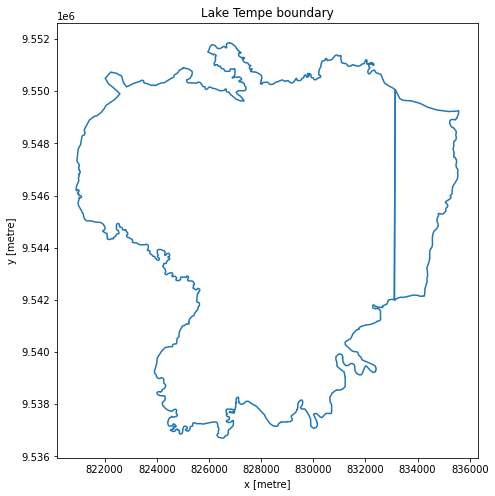

In [18]:
### Reproject to current coordinate reference system
shp = shp.to_crs(native_crs)

### Remove unwanted polygons
print("Selected polygons are:")
drop_list = []
for ff in shp.iterrows():
    tmp = ff[1].Village.lower()
    if 'tempe' in tmp and 'danau' in tmp: print(ff[0],ff[1].Village)
    else: drop_list.append( ff[0] )
        
shp.drop( drop_list, inplace=True )

### Plot
shp.boundary.plot(figsize=(8,8))
plt.xlabel("x [metre]"); plt.ylabel("y [metre]")
plt.title("Lake Tempe boundary");

## Raster mask

We can now create a raster mask from the vector data. The code below iterates over the polygons in the shapefile (in case multiple polygons are available), setting the raster mask values to `1` for all the pixels located within the footprint of each polygon, and `0` otherwise.

In [19]:
### Rasterise
mask = rasterio.features.rasterize( ((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                    out_shape = (data.dims['y'],data.dims['x']),
                                    transform = data.affine )

### Convert the mask (numpy array) to an Xarray DataArray
mask = xr.DataArray(mask, coords=(data.y, data.x))
mask

<xarray.DataArray (y: 623, x: 632)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 9.535e+06 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x        (x) float64 8.187e+05 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05

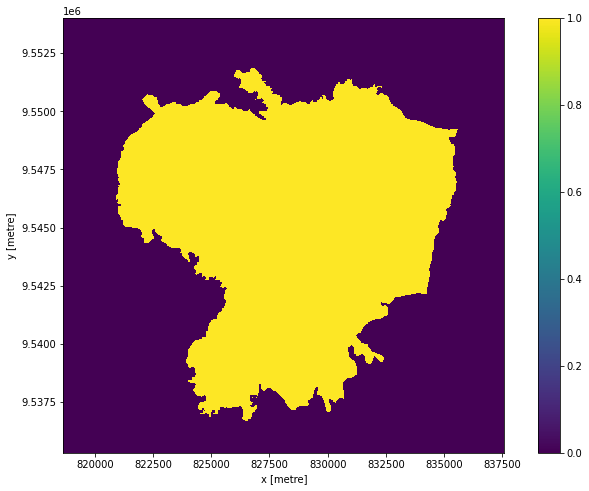

In [20]:
### Plot
mask.plot(size=8).axes.set_aspect('equal')

## Masking the data

Finally, we can use the mask we just created, apply it to the time series of Sentinel-2 data, and plot the result.

In [21]:
### Masking
data = data.where(mask).persist()

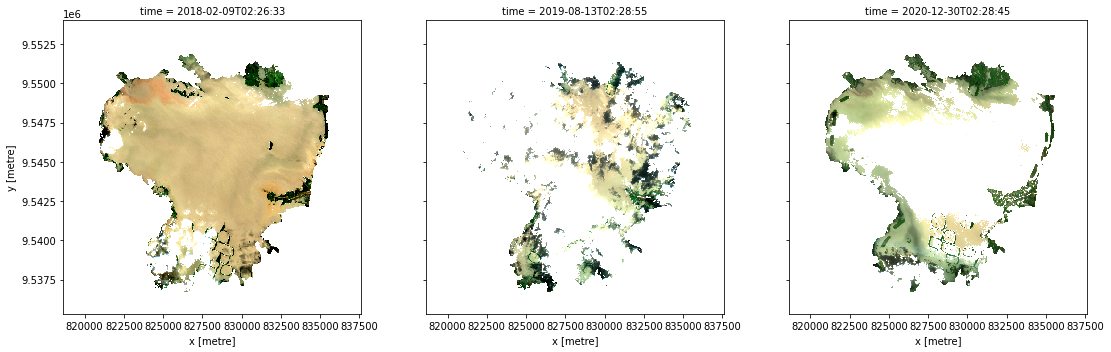

In [22]:
tmp = np.linspace(1, data.sizes['time'], 3, dtype='int') - 1   # select some time slices to display

### Plot the selected time slices (true-colour display)
image_array = data[['red', 'green', 'blue']].isel(time=tmp).to_array()
tmp = image_array.plot.imshow(robust=True, col='time', col_wrap=3, size=5)
for ax in tmp.axes.flatten(): ax.set_aspect('equal')

We now have a cropped data time series containing only the pixels of interest over Lake Tempe. 

However, due to the varying extents of the lake over time (during wet / dry conditions), some time slices in the time series will contain a certain number of non-water (i.e. land) pixels. Further below, the TSS algorithm would thus also be applied to these land / vegetation pixels, thereby leading to some bias in the results.

# Filtering out land &#40;i.e. non-water&#41; pixels

In order to address this issue, we could try to use the modified normalised difference water index (MNDWI) in order to filter out the non-water pixels. 

## Water index

The MNDWI is calculated on the basis of the Sentinel-2 bands as per the following equation, with MNDWI values greater than 0 indicating water pixels:

$$
\text{MNDWI}= \frac{ \text{green}−\text{SWIR} }{ \text{green}+\text{SWIR} }.
$$

So let's apply this formula to the Sentinel-2 dataset, and save the resulting MNDWI data back into the `data` object as an additional band.

In [23]:
data['MNDWI'] = ( (data.green - data.swir_2) / (data.green + data.swir_2) ).persist()
data

<xarray.Dataset>
Dimensions:      (time: 198, y: 623, x: 632)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2020-12-30T02:...
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x            (x) float64 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05
    spatial_ref  int32 32750
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    swir_2       (time, y, x) float64 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    qa           (time, y, x) float64 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
    MNDWI        (time, y, x) float64 dask.array<chunksize=(1, 623, 632), meta=np.ndarray>
Attributes:
    crs:           EPSG:32750
    grid_mapping:  spatial_ref

As shown above, we now have the MNDWI band integrated as part of the `data` (Dask) array. For insight, we can also plot a few MNDWI time slices to investigate the results further.

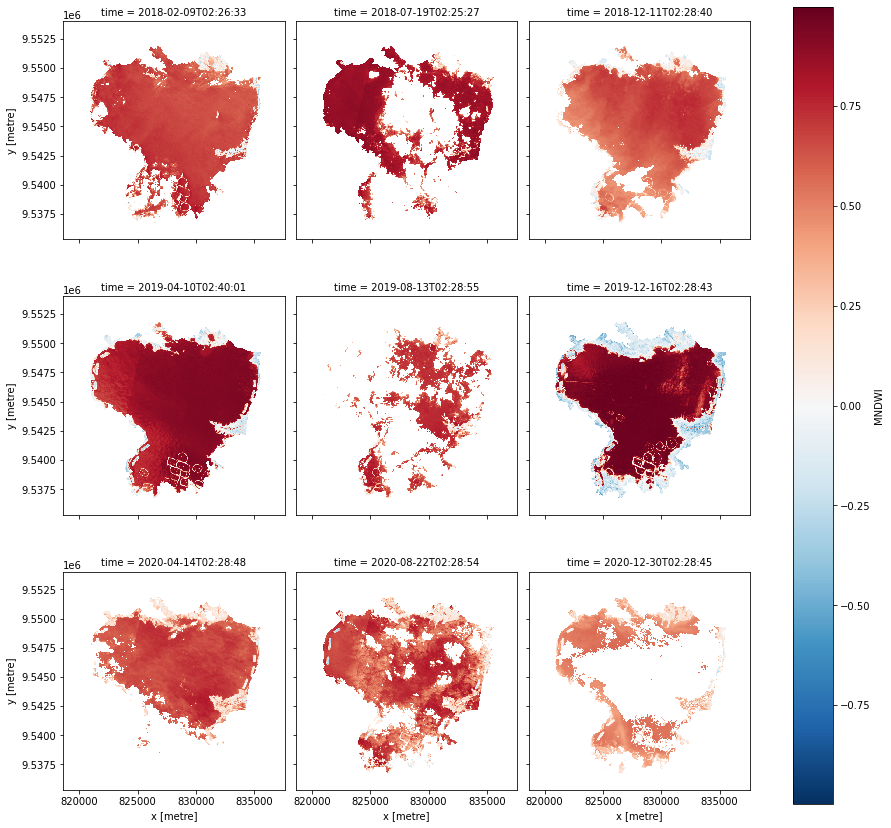

In [24]:
tmp = np.linspace(1, data.sizes['time'], 9, dtype='int') - 1   # select some time slices to display
tmp = data.MNDWI[tmp].plot(col='time', col_wrap=3, size=4)
for ax in tmp.axes.flatten(): ax.set_aspect('equal')

This approach appears to provide good results for the current Sentinel-2 dataset, with various regions on the edge of the lake clearly identified as being non-water (MNDWI values below 0.0).

## Removing non-water pixels

We can now use the MNDWI information to remove the non-water pixels from the time series.

In [25]:
data = data.where(data.MNDWI>0.0).persist()

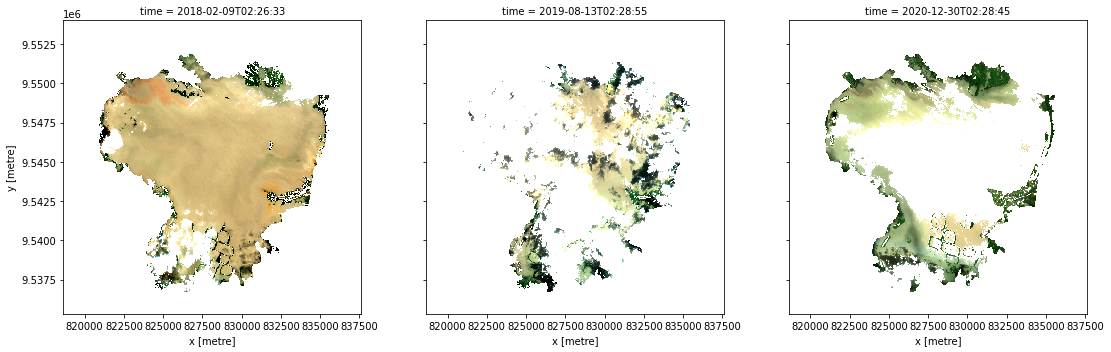

In [26]:
tmp = np.linspace(1, data.sizes['time'], 3, dtype='int') - 1   # select some time slices to display

### Plot the selected time slices (true-colour display)
image_array = data[['red', 'green', 'blue']].isel(time=tmp).to_array()
tmp = image_array.plot.imshow(robust=True, col='time', col_wrap=3, size=5);
for ax in tmp.axes.flatten(): ax.set_aspect('equal')

# TSS analysis

## TSS calculation

As per the formula provided at the start of this notebook, TSS values can be calculated for each pixel in the time series on the basis of the selected Sentinel-2 bands.

In [27]:
### TSS calculation
tmp = data.red + data.green
nsmi = (tmp - data.blue) / (tmp + data.blue)
data_tss = (775.98 * nsmi - 93.606).persist()
data_tss

<xarray.DataArray (time: 198, y: 623, x: 632)>
dask.array<sub, shape=(198, 623, 632), dtype=float64, chunksize=(1, 623, 632), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2020-12-30T02:...
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x            (x) float64 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05
    spatial_ref  int32 32750

## Selected displays

### Individual time slices

For insight, let's take a look at the TSS data at a few selected time points.

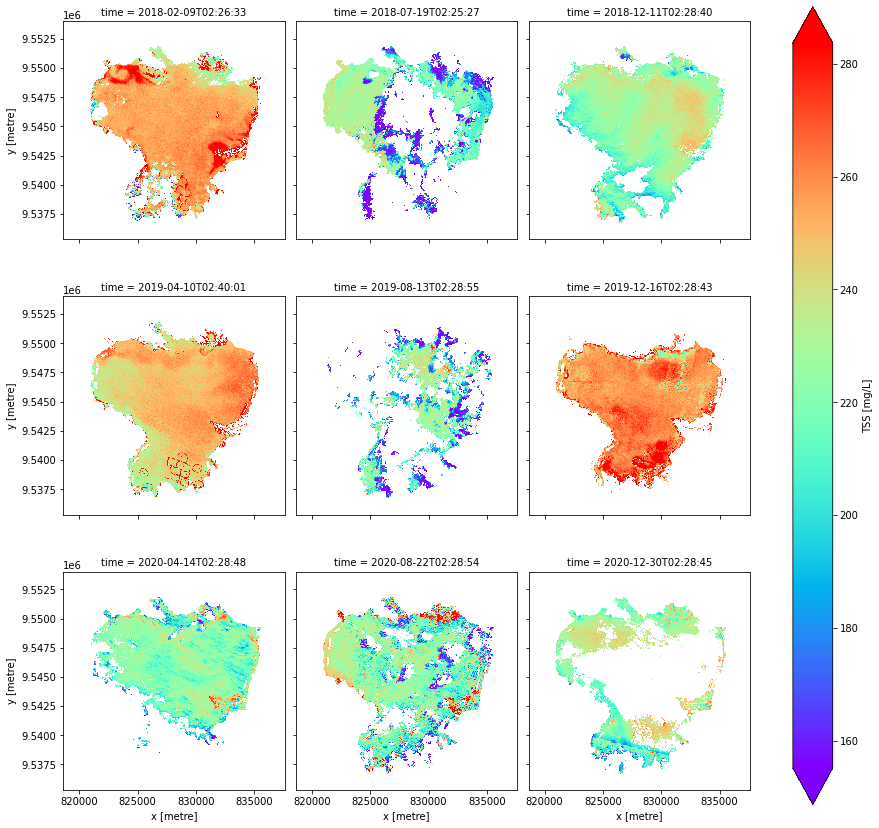

In [28]:
tmp = np.linspace(1, data_tss.sizes['time'], 9, dtype='int') - 1   # some selected time slices to display

### Main plot
tmp = data_tss[tmp].plot( col='time', col_wrap=3, cmap='rainbow', size=4, robust=True,
                          cbar_kwargs = dict(label="TSS [mg/L]") )
for ax in tmp.axes.flatten(): ax.set_aspect('equal')

We can here clearly see that some pixel quality issues are still affecting the datasets, e.g. with residual areas of cloud shadow not having been removed successfully during the data clean-up process.

### Temporal aggregation &#40;1&#41;

While these "daily" TSS plots can be insightful, the abundance of missing (and corrupt) data, as well as the many time slices in the time series, make for a difficult assessment of the results. One approach to circumvent this is to first aggregate the data over coarser time spans, and then display the average TSS over these periods.

`Xarray` allows for a straightforward aggregation of the data according to [Pandas indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) using the `dateoffset` functionality. For instance, we could calculate the temporal mean of the data over yearly quarters (with the first quarter ending in January):

In [29]:
data_tss_quarter = data_tss.resample(time="QS-JAN").mean()   # aggregation over each successive quarter
data_tss_quarter = data_tss_quarter.persist()
data_tss_quarter

<xarray.DataArray (time: 12, y: 623, x: 632)>
dask.array<stack, shape=(12, 623, 632), dtype=float64, chunksize=(1, 623, 632), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01 2018-04-01 ... 2020-10-01
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x            (x) float64 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05
    spatial_ref  int32 32750

As we can see from the resulting Xarray object, there is a total of 12 quarters in the current time series, leading to 12 "time slices" in the resulting array.

Then, as done before for the daily time series, we can select a few of the resulting quarters and plot the respective (temporally averaged) TSS maps.

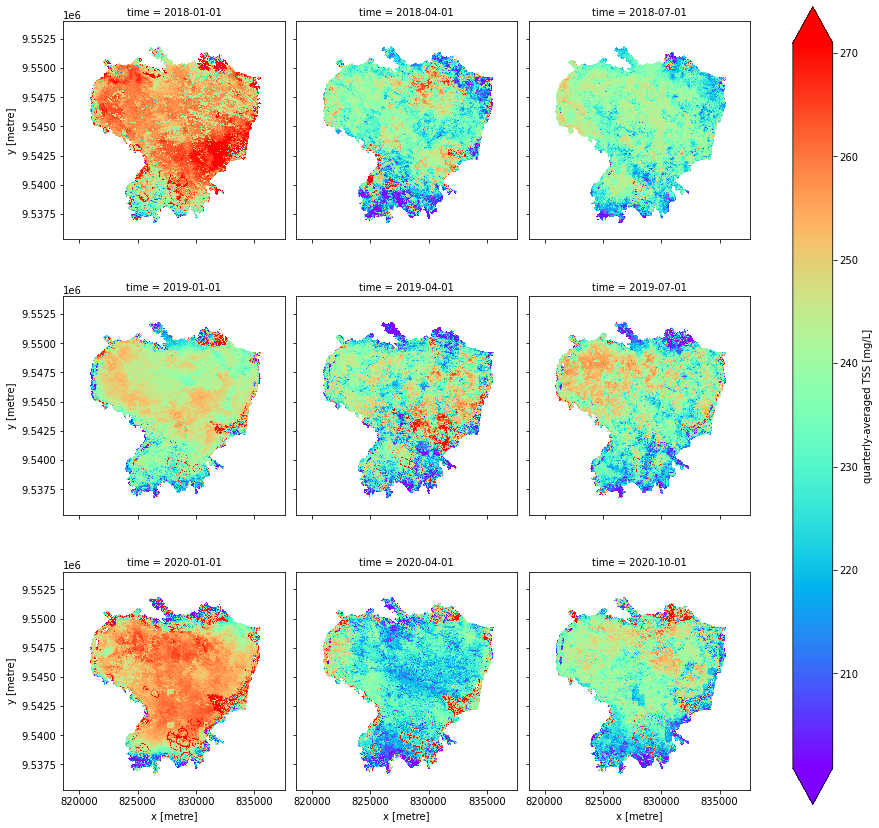

In [30]:
tmp = np.linspace(1, data_tss_quarter.sizes['time'], 9, dtype='int') - 1   # some selected time slices to display

### Main plot
tmp = data_tss_quarter[tmp].plot( col='time', col_wrap=3, cmap='rainbow', size=4, robust=True,
                                  cbar_kwargs = dict(label="quarterly-averaged TSS [mg/L]") )
for ax in tmp.axes.flatten(): ax.set_aspect('equal')

Here we can see that a clearer picture of the temporal TSS dynamics / characteristics is starting to emerge for each averaging period (quarter) along the selected time series.

### Temporal aggregation &#40;2&#41;

Another potential way to temporally aggregate the time series data is to calculate the average TSS values for _all_ time slices in specific periods such as months, seasons, quarters, etc. In other words, while the previous plots present averaged results over successive quarters (resulting in a total of 12 quarters for the current time series), we could now average the data from _all_ the time slices within, e.g., a given month or season (regardless of the year). This would provide an overview of the average TSS concentration in various months or seasons in any given year.

For illustration, let's apply this approach to calculate the average TSS maps for each individual month in our time series &ndash; this is done by essentially collecting _all_ the January time slices to calculate the January average, and so forth for all other months.


In [31]:
data_tss_group = data_tss.groupby("time.month").mean().persist()   # aggregation over each month
data_tss_group = data_tss_group
data_tss_group

<xarray.DataArray (month: 12, y: 623, x: 632)>
dask.array<stack, shape=(12, 623, 632), dtype=float64, chunksize=(1, 623, 632), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.554e+06 9.554e+06
  * x            (x) float64 8.187e+05 8.187e+05 ... 8.376e+05 8.376e+05
    spatial_ref  int32 32750
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

As can be seen here, the result of this operation is a DataArray with a new dimension (`month`) and 12 coordinates along it &ndash; one "slice" for each individual month.

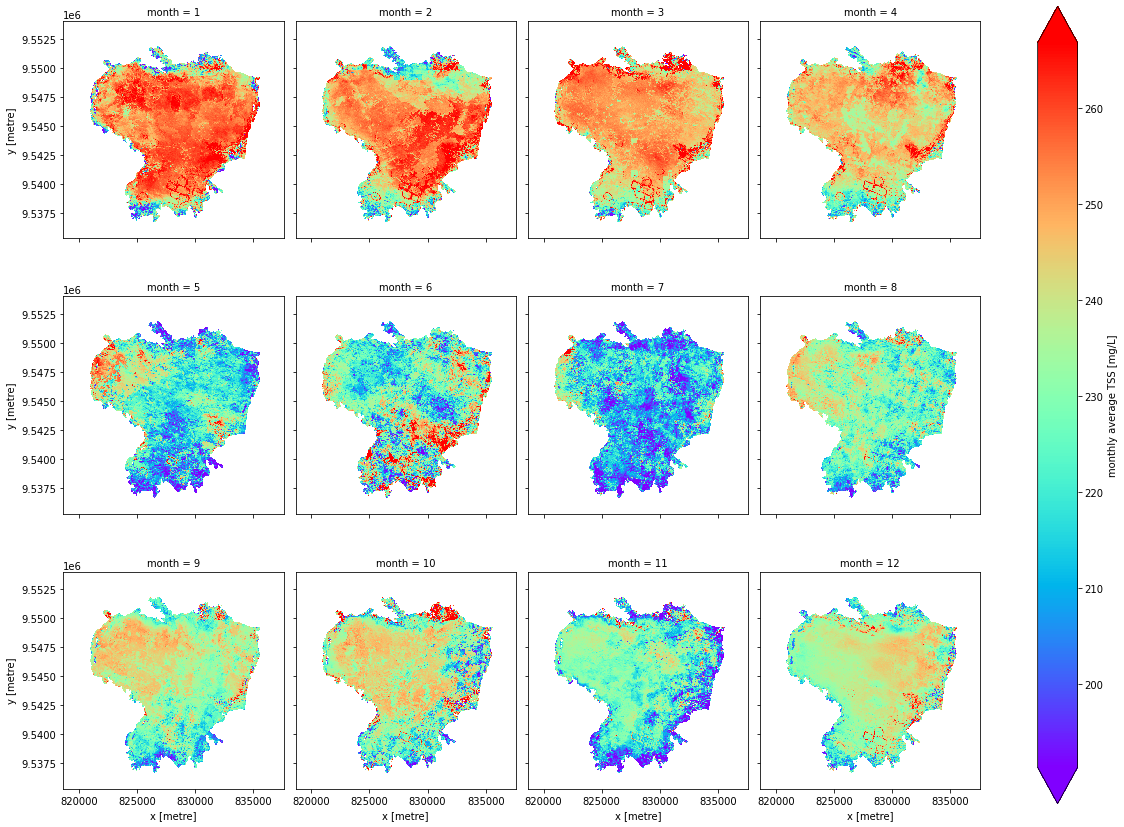

In [32]:
tmp = data_tss_group.plot( col='month', col_wrap=4, cmap='rainbow', size=4, robust=True,
                           cbar_kwargs = dict(label="monthly average TSS [mg/L]") )
for ax in tmp.axes.flatten(): ax.set_aspect('equal')

This plot seems to indicate that, over the whole time series under current consideration, the months between January and April generally exhibit elevated levels of TSS over most of Lake Tempe. In contrast, lower values of TSS are recorded, on average, during the months of May, June and July.

<div class="alert alert-info"><font color="black"><b>Caution &ndash;</b> Once again, this result should be here treated with caution, and further analyses should be carried out to ensure that the data time series leading to this result is completely free of any potential pixel quality issues and artefacts.</font></div>
    
## Temporal statistics &#40;standard&#41;

The overall TSS average across the _entire_ time series, for each pixel, can be easily calculated as follows.

In [33]:
data_tss_mean = data_tss.mean('time')   # standard mean over entire time series
data_tss_mean = data_tss_mean.persist()

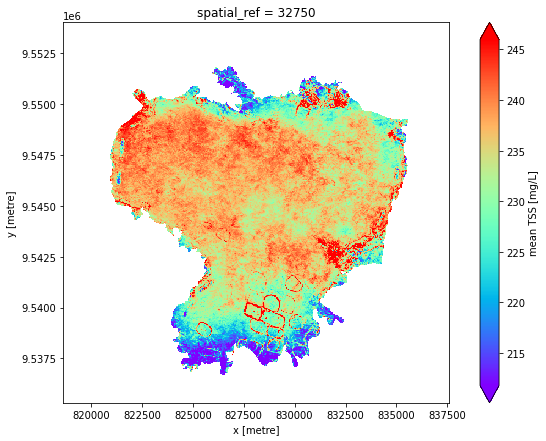

In [34]:
### Plot
fig = plt.figure(figsize=(11,7))
data_tss_mean.plot(robust=True, cmap='rainbow', cbar_kwargs={'label':'mean TSS [mg/L]'})
plt.gca().set_aspect('equal','box');

This map provides an overview of the overall TSS concentrations for the region of interest and over the entire specified time span.

From the previous results in this notebook, however, we should expect that the above plot integrates a number of pixels for which the pixel QA clean-up proess has failed. For instance, some pixels affeted by cloud shadows may not have been successfully masked out, leading to erroneously low TSS values in some time slices. These problematic TSS values have subsequently been used in the computation of the above average plot, leading to potentially biased results.

## Robust statistics &#40;using Dask&#41;

### Approach

In order to minimise the impact from such outliers, we could make use of a more _robust_ metric of temporal averaging instead of the simple `.mean()` operation used earlier. For instance, one such metric would be to calculate the _median_ TSS instead.

Here, we will use another approach, which is to define our own (custom) function and apply it to the Xarray / Dask array of TSS data (`data_tss`). The aim here is to instruct `Xarray` to take each pixel, apply the function to the corresponding TSS time series (along the `time` dimension), and aggregate the results to produce a map with two `x` and `y` dimensions. And given the Dask arrays at hand, we would also like this process to occur in a parallelised fashion on all CPUs available in this JupyterLab environment.

### Robust functions

In the next cell, we start by defining a `robust_mean()` function, which operates as follow on a Numpy vector `z` of input data:

1. remove `Nan`s from the data
1. remove outliers from the data using the `sigma_clip` function
1. calculate and return the (standard) mean of the filtered data (`NaN`s and outliers removed) &ndash; if the filtered vector contains less than 10 data points, simply return `NaN` instead.

Further below, this function will be applied, in a parallelised fashion, to the Dask array of TSS values &ndash; essentially, `robust_mean()` will receive as input `z` the time series of TSS values for each pixel in turn. The returned value of the pixel's (robust) average TSS will then be used to build the resulting map of average mean TSS, calculated in a robust way.

In addition, we here also define another function (`robust_cv()`) to calculate the _coefficient of variation_ (CV) for the same time series of TSS data (at each pixel). As shown below, the CV is simply defined as the standard deviation of the input values, divided by the mean &ndash; here again, calculated in a robust manner on the basis of the filtered vector of data.

In [35]:
def robust_mean(z):
    zf = z[~np.isnan(z)]   # filter out NaNs
    if len(zf)<10: return np.nan   # use at least 10 values to compute the mean
    zf = sigma_clip( zf, masked=False )   # remove outliers
    return np.mean(zf)   # mean of data without outliers

def robust_cv(z):
    zf = z[~np.isnan(z)]   # filter out NaNs
    if len(zf)<10: return np.nan   # use at least 10 values to compute the CV
    zf = sigma_clip( zf, masked=False )   # remove outliers
    return np.std(zf) / np.mean(zf)   # CV of data without outliers

### Applying parallelised custom functions

In the following cell, the `robust_mean` function is applied in a parallelised fashion to the dataset by making use of the `apply_ufunc()` function in `Xarray` &ndash; another way to carry out this operation would be to use `xr.map_blocks()`.

In [36]:
### Re-chunk Dask array for efficient time-series processing
data_tss = data_tss.chunk({'time':-1, 'x':32, 'y':32}).persist()

### Parallelised processing
data_tss_robMean = xr.apply_ufunc( robust_mean, data_tss, input_core_dims=[["time"]], 
                                   dask='parallelized', vectorize=True )   # robust mean, whole time series
data_tss_robMean = data_tss_robMean.persist()

Our second custom function can now be applied in the same way to the TSS data.

In [37]:
data_tss_robCV = xr.apply_ufunc( robust_cv, data_tss, input_core_dims=[["time"]], 
                                 dask='parallelized', vectorize=True )   # robust mean, whole time series
data_tss_robCV = data_tss_robCV.persist()

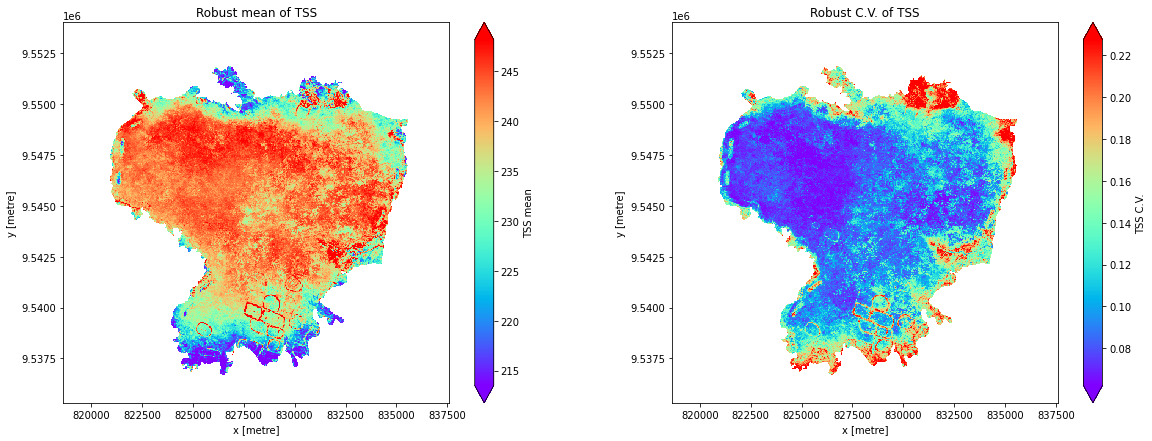

In [38]:
### Plots
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))

data_tss_robMean.plot(robust=True, cmap='rainbow', cbar_kwargs={'label':'TSS mean'}, ax=ax1)
ax1.set_title(f"Robust mean of TSS")
ax1.set_aspect('equal','box')

data_tss_robCV.plot(robust=True, cmap="rainbow", cbar_kwargs={'label':'TSS C.V.'}, ax=ax2)
ax2.set_title(f"Robust C.V. of TSS")
ax2.set_aspect('equal','box');

### Discussion

The plot of robust mean values (left-hand side) has not changed significantly compared to the previous plot of the (standard) average values. However, the fact that we have used a robust metric for the temporal averaging operation gives us more confidence in the validity of the plotted results, in particular with respect to the residual pixel quality issues affecting the considered TSS dataset.

On the right-hand side, the CV map provides further insight into the temporal dynamics in the TSS dataset, highlighting a number of "hot spots" with elevated TSS variability near the edge of the lake (perhaps as a result of regular sediment contribution from specific rivers / tributaries to the lake waters).

A final note here is with regards to the range of (average) TSS values displayed in the above plot (left-hand side). In the Pandhadha _et al._ paper cited at the beginning of this notebook, the authors report that the field measurements of TSS in Lake Tempe are ranging between 115 and 203 mg/L, which is (roughly) in the same order of magnitude as the values displayed in the plot. We can thus have some confidence that the TSS algorithm used in this notebook at least provides TSS data that appears to be sensible, though further validation work is required to determine whether the TSS algorithm used here provides accurate results for the range of values experienced in this notebook. 

# Extracting TSS data for further analysis &#40;pixel drills&#41;

## Time series indexing

At this point, a practitioner might want to extract the time series of TSS values at selected locations, display them, and potentially write them to file to be used as input to further processing or modelling work.

We demonstrate this by first selecting a few points of interest, e.g. along a transect line across the region of interest.

In [39]:
### Some pixels along a transect
n_points = 5
pixloc_y = np.linspace(9547000, 9545000, n_points)
pixloc_x = np.linspace(825000, 832000, n_points)

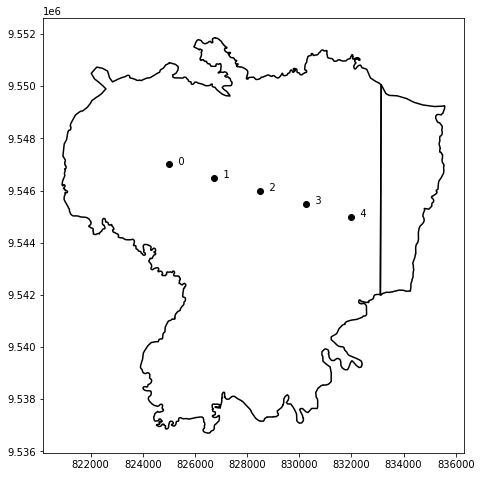

In [40]:
### Plot
fig = plt.figure(figsize=(8,8))
plt.plot(pixloc_x, pixloc_y, marker='o', color='black', linestyle='none')
shp.boundary.plot(ax=fig.axes[0], color='black');
[plt.text(x,y,f"{p:4d}") for p,(y,x) in enumerate(zip(pixloc_y,pixloc_x))];

We can now extract the pixels' TSS data using `Xarray`'s vectorised indexing functionality, which will retrieve data at the grid cells nearest to the target `x` and `y` coordinates. For illustration purposes, here we make use of the time series of quarterly averaged TSS values.

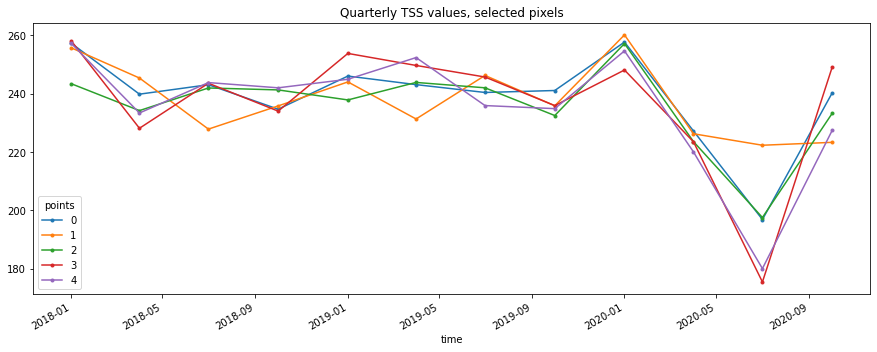

In [41]:
points_x = xr.DataArray(pixloc_x, dims="points")
points_y = xr.DataArray(pixloc_y, dims="points")

### Extract data (quarterly dataset)
points_dat = data_tss_quarter.sel(x=points_x, y=points_y, method="nearest")
points_dat = points_dat.dropna('time', how='all')
points_dat = points_dat.persist()

### Plot
points_dat.plot.line(x='time', marker='.', figsize=(15,5));
plt.gca().set_title("Quarterly TSS values, selected pixels");

From this plot, we can clearly identify a period of decreased TSS levels at all point of interest, preceded by a series of higher TSS concentrations.

## Extracting to Pandas data frame

The following code cell will save the sampled (quarterly) TSS data into a Pandas data frame:

In [42]:
### Extract to Pandas
tss_df = pd.DataFrame( data = points_dat.values, 
                       index = points_dat.time.values, 
                       columns = points_dat.points.values )

### (Re)set DF index
tss_df['month'] = tss_df.index.month
tss_df['year'] = tss_df.index.year
tss_df = tss_df.set_index(['year','month'])

tss_df

0           1           2           3           4
year month                                                            
2018 1      257.328187  255.746486  243.432876  258.141784  257.270748
     4      239.850518  245.384545  234.216527  228.154045  233.387142
     7      243.093750  227.865623  241.973659  243.599509  243.826203
     10     234.700149  235.814439  241.310443  234.036187  242.029936
2019 1      246.057517  244.055116  237.870309  253.824961  244.962170
     4      243.122051  231.340612  243.874545  249.701082  252.403634
     7      240.431704  246.273665  242.032411  245.729081  235.939214
     10     241.107097  235.867842  232.526281  235.926385  234.887090
2020 1      257.720366  260.185931  257.203648  248.134618  254.689527
     4      227.229722  226.268307  223.584198  223.522187  220.059563
     7      196.855836  222.331840  197.541845  175.431366  180.029425
     10     240.256243  223.326796  233.247971  249.078397  227.405634

If desired, we can also "re-format" the data frame into a long (as opposed to wide) format:

In [43]:
tss_df = tss_df.stack(dropna=False).rename_axis(['year','month','point'])
tss_df = pd.DataFrame(tss_df).rename(columns={0:'TSS'})
tss_df

TSS
year month point            
2018 1     0      257.328187
           1      255.746486
           2      243.432876
           3      258.141784
           4      257.270748
     4     0      239.850518
           1      245.384545
           2      234.216527
           3      228.154045
           4      233.387142
     7     0      243.093750
           1      227.865623
           2      241.973659
           3      243.599509
           4      243.826203
     10    0      234.700149
           1      235.814439
           2      241.310443
           3      234.036187
           4      242.029936
2019 1     0      246.057517
           1      244.055116
           2      237.870309
           3      253.824961
           4      244.962170
     4     0      243.122051
           1      231.340612
           2      243.874545
           3      249.701082
           4      252.403634
     7     0      240.431704
           1      246.273665
           2      242.032411
           3      245.729081
           4      235.939214
     10    0      241.107097
           1      235.867842
           2      232.526281
           3      235.926385
           4      234.887090
2020 1     0      257.720366
           1      260.185931
           2      257.203648
           3      248.134618
           4      254.689527
     4     0      227.229722
           1      226.268307
           2      223.584198
           3      223.522187
           4      220.059563
     7     0      196.855836
           1      222.331840
           2      197.541845
           3      175.431366
           4      180.029425
     10    0      240.256243
           1      223.326796
           2      233.247971
           3      249.078397
           4      227.405634

And finally, saving the data (e.g. to `.csv` or `.pkl` file) can be achieved with the following code if desired.

In [44]:
### Uncomment if needed:
# tss_df.to_csv('./TSS_pixel_data.csv')
# tss_df.to_pickle(path='./TSS_pixel_data.pkl')

In [45]:
### End notebook